# Example 5: Markov Stability on hypergraphs

Here, we implement the methodology defined in https://arxiv.org/pdf/2010.14355.pdf

In [ ]:
# The hypernetx package for hypergraphs: https://github.com/pnnl/HyperNetX
!pip install hypernetx

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sc
import scipy.sparse as sp
import itertools

import matplotlib.pyplot as plt

import pygenstability as pgs
from pygenstability import plotting

import hypernetx as hnx

## Synthetic hypergraph 

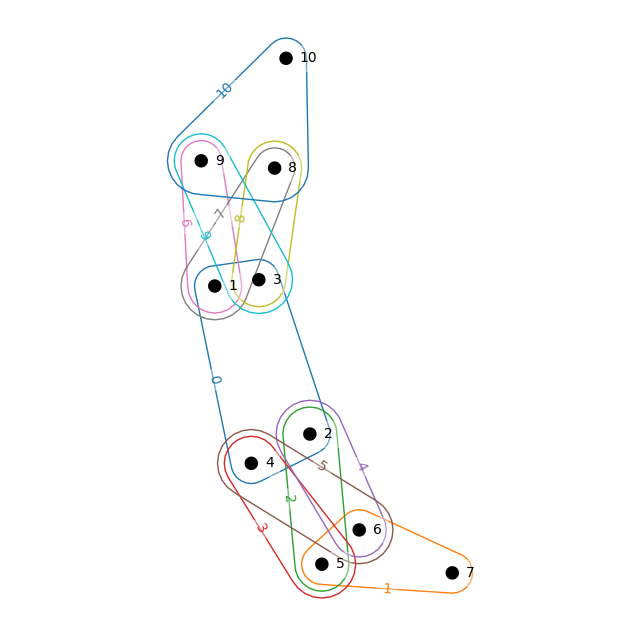

In [3]:
# construct example with 3 hyperedges acting as communities
edges = {
    0: ('1','2','3','4'),
    1: ('5','6','7'),
    2: ('2','5'),
    3: ('4','5'),
    4: ('2','6'),
    5: ('4','6'),
    6: ('1','9'),
    7: ('1','8'),
    8: ('3','8'),
    9: ('3','9'),
    10: ('8','9','10'),
}

hyper_graph = hnx.Hypergraph(edges)
hnx.draw(hyper_graph)

# Projection of hypergraph

In [4]:
# construct projected matrix (no hyperedges)
incidence = hyper_graph.incidence_matrix().toarray()    
graph_projection = np.matmul(incidence, incidence.T)
np.fill_diagonal(graph_projection, 0)
graph = sp.csr_matrix(graph_projection)

# construct network object just for plotting
nx_graph = nx.Graph(graph)
pos = nx.spring_layout(nx_graph, weight=None, scale=1)
for u in nx_graph:
    nx_graph.nodes[u]["pos"] = pos[u]


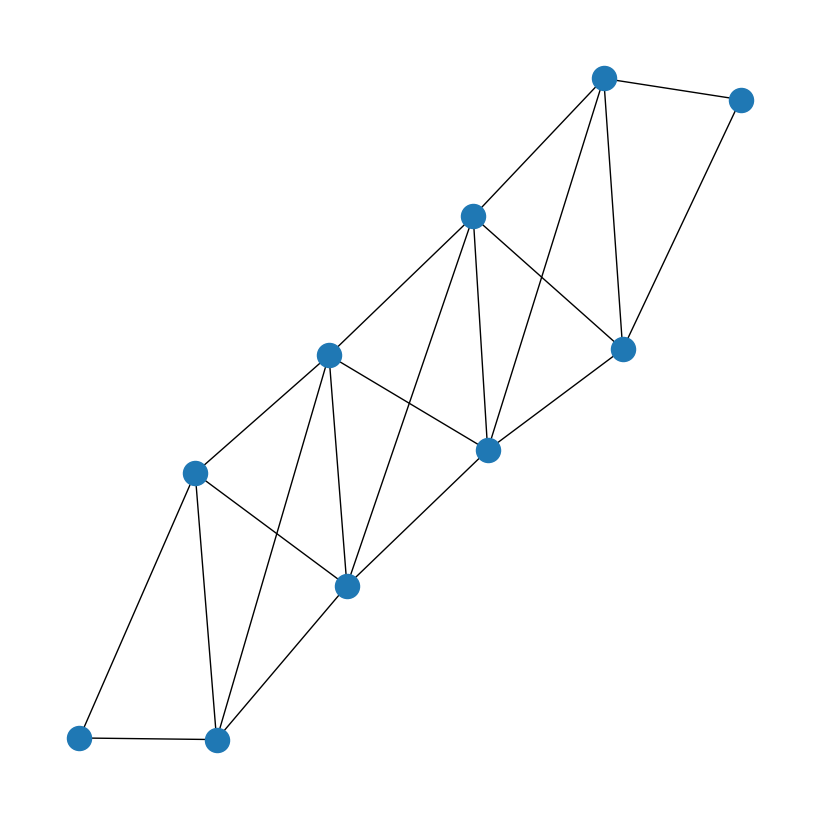

In [5]:
# plotting projection of hypergraph 
nx.draw(nx_graph, pos)

In [6]:
results_hypergraph_projection = pgs.run(graph, min_scale=-1.5, max_scale=2., n_scale=50,
                                        constructor='continuous_normalized',with_optimal_scales=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.84it/s]


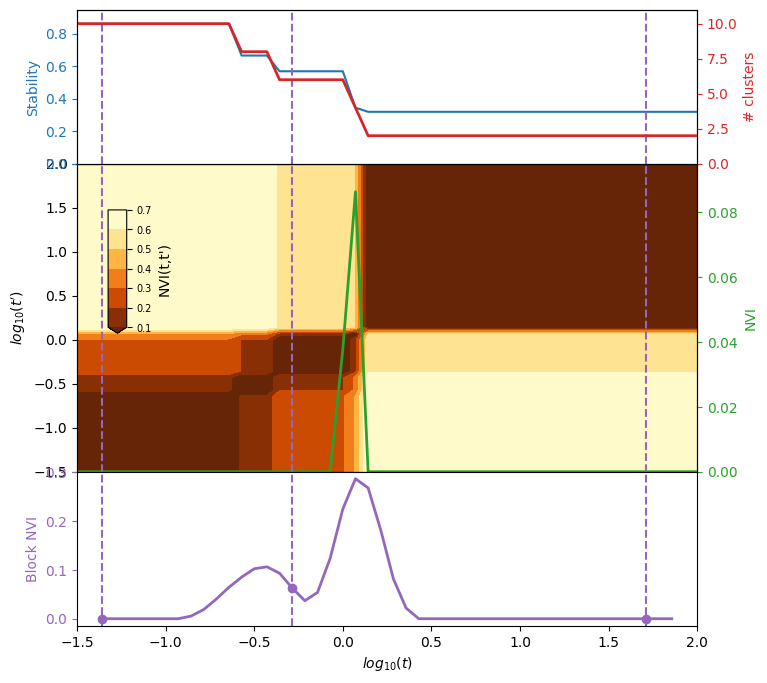

In [7]:
_ = plotting.plot_scan(results_hypergraph_projection)

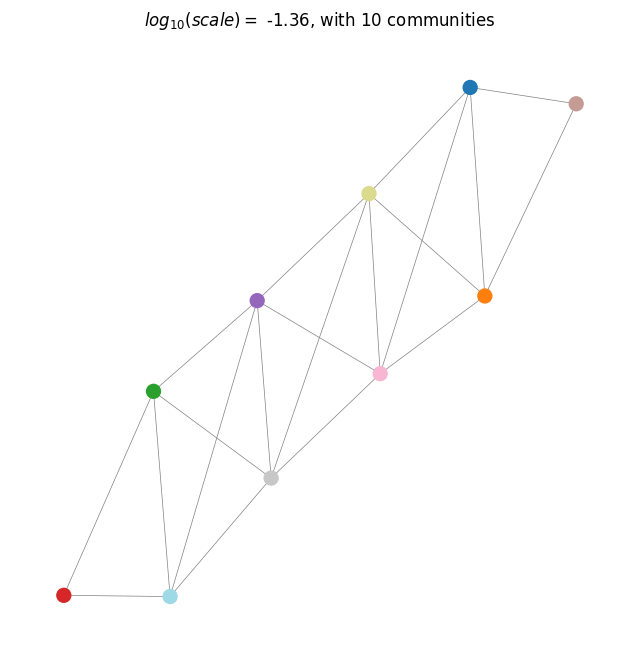

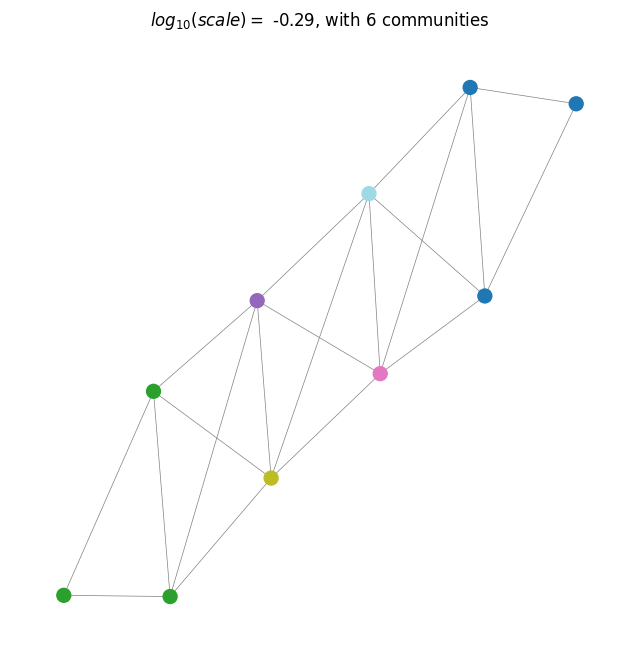

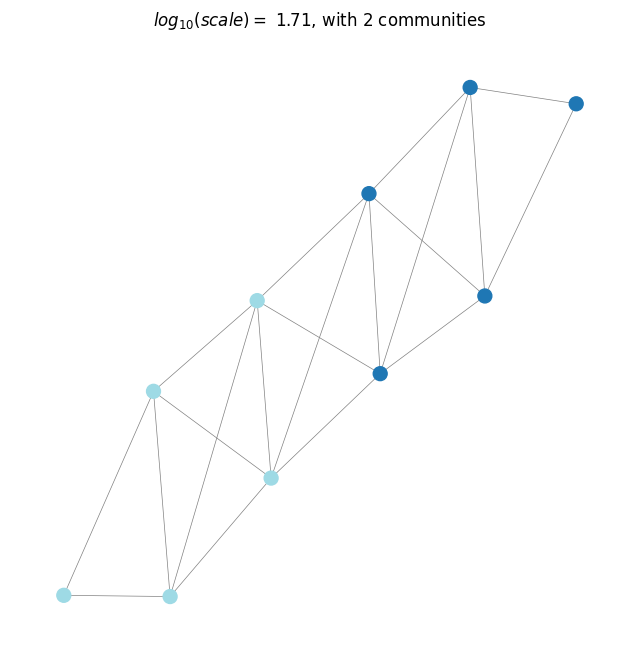

In [8]:
# plot the partition at the optimal scale
for scale in results_hypergraph_projection['selected_partitions']:
    plt.figure()
    plotting.plot_single_partition(nx_graph, results_hypergraph_projection, scale_id=scale)

# Equivalent weighted graph

Notice that above we don't identify the 3 communities related to the 3 hyperedges. The information was lost during the projection. Lets use Carletti's approach to retain the weighted interactions.

In [9]:
# defining equivalent weighted network 

def get_adjacency(H):
    """Construct Laplacian for HyperGraph H.
    
    Args:
        H: Hypernetx hypergraph object
    """
    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T, incidence)
    A = np.matmul(incidence, incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)), incidence.T))

    # defining transition matrix
    adj = R - A
    np.fill_diagonal(adj, 0)
    
    return adj

In [10]:
# adjacency matrix constructed using Carletti method
graph_ew = sp.csr_matrix(get_adjacency(hyper_graph))

In [11]:
results_hypergraph_ew = pgs.run(graph_ew, min_scale=-1.5, max_scale=2.5, n_scale=50,
                                constructor='continuous_normalized',with_optimal_scales=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.05it/s]


/Users/arnaudon/code/PyGenStability/src/pygenstability/plotting.py:341: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



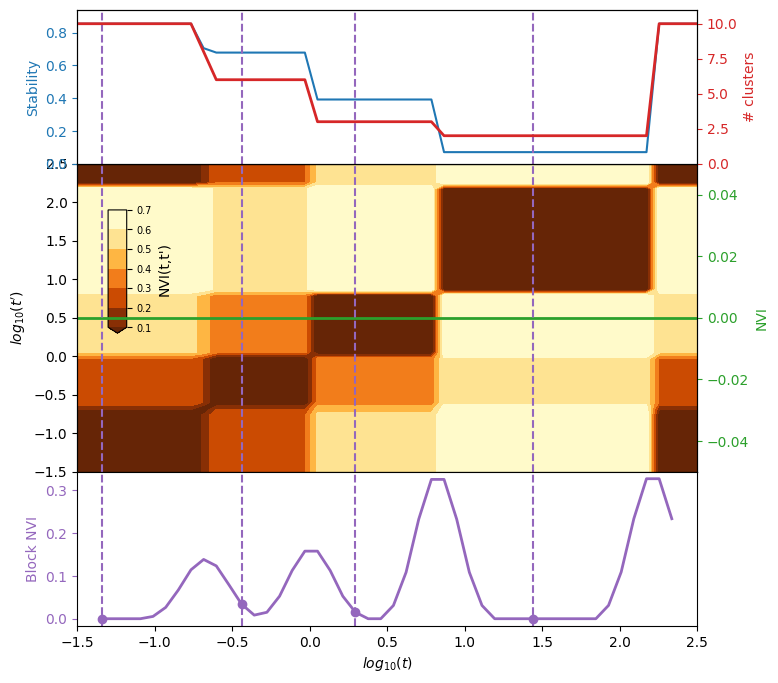

In [12]:
# note the 3-way partition that now appears
_ = plotting.plot_scan(results_hypergraph_ew)

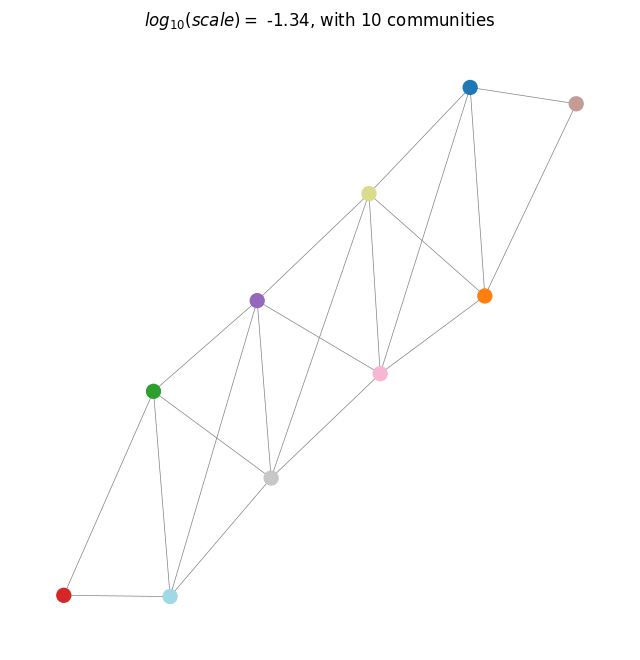

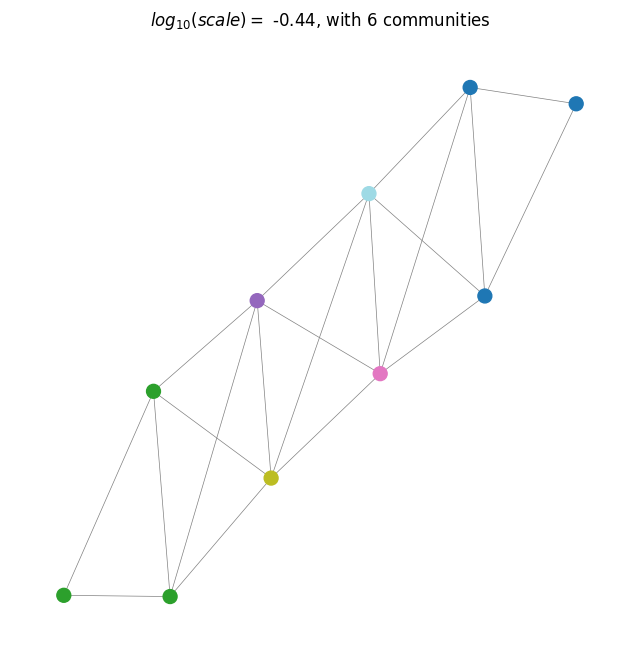

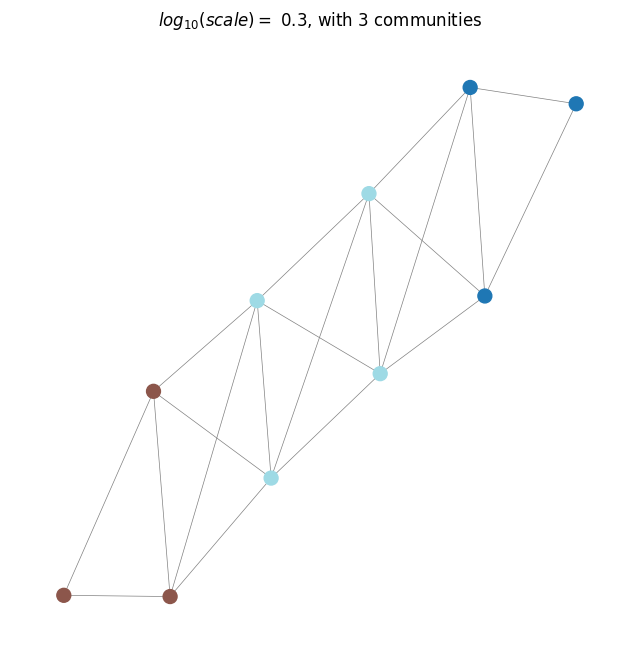

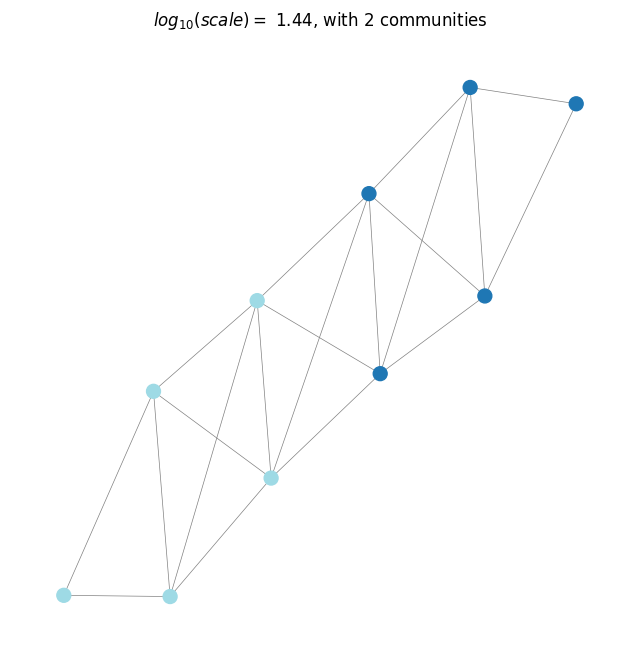

In [13]:
# plot the partition at the optimal scale
for scale in results_hypergraph_ew['selected_partitions']:
    plt.figure()
    plotting.plot_single_partition(nx_graph, results_hypergraph_ew, scale_id=scale)